# 프로젝트 : Seq2seq으로 번역기 만들기

## 1. 데이터 준비하기
- **데이터 불러오기**
- **데이터 전처리**

## 2. 모델 설계하기

## 3. 모델 학습하기

## 4. 모델 학습 결과

In [ ]:
#! mkdir -p ~/aiffel/GoingDeeper/dataset/seq2seq

In [ ]:
import tensorflow as tf
import numpy as np

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import time, re, os, io

print(tf.__version__)

2.6.0


In [ ]:
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

- - -
### 데이터 준비하기
- **데이터 불러오기**

In [ ]:
ko_path = os.getenv('HOME') + '/aiffel/GoingDeeper/dataset/seq2seq/korean-english-park.train.ko'
en_path = os.getenv('HOME') + '/aiffel/GoingDeeper/dataset/seq2seq/korean-english-park.train.en'

with open(ko_path, 'r') as f:
    kor = f.read().splitlines()
    
with open(en_path, 'r') as f:
    eng = f.read().splitlines()

print(len(kor))
print(len(eng))

94123
94123


In [ ]:
import pandas as pd

corpus = pd.DataFrame([kor, eng], index=['kor', 'eng']).T

corpus

,kor,eng
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
94118,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...
94119,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si..."
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.


저는 데이터를 불러오자 마자 다루기 쉽도록 pandas 데이터 프레임으로 생성해줬습니다.

In [ ]:
corpus.drop_duplicates(inplace=True)
corpus.dropna(how='any', inplace=True)
corpus = corpus.reset_index(drop=True)

corpus

,kor,eng
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
78963,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...
78964,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si..."
78965,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...
78966,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.


바로 중복 제거와 결측치 제거를 해줍니다.

- - -
### 데이터 준비하기
- **데이터 전처리**

In [ ]:
kor_len = [len(i.split()) for i in corpus['kor']]
eng_len = [len(i.split()) for i in corpus['eng']]

print('한글 데이터의 최장 길이 :', max(kor_len))
print('한글 데이터의 최단 길이 :', min(kor_len))
print('영어 데이터의 최장 길이 :', max(eng_len))
print('영어 데이터의 최단 길이 :', min(eng_len))

한글 데이터의 최장 길이 : 82
한글 데이터의 최단 길이 : 1
영어 데이터의 최장 길이 : 90
영어 데이터의 최단 길이 : 1


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


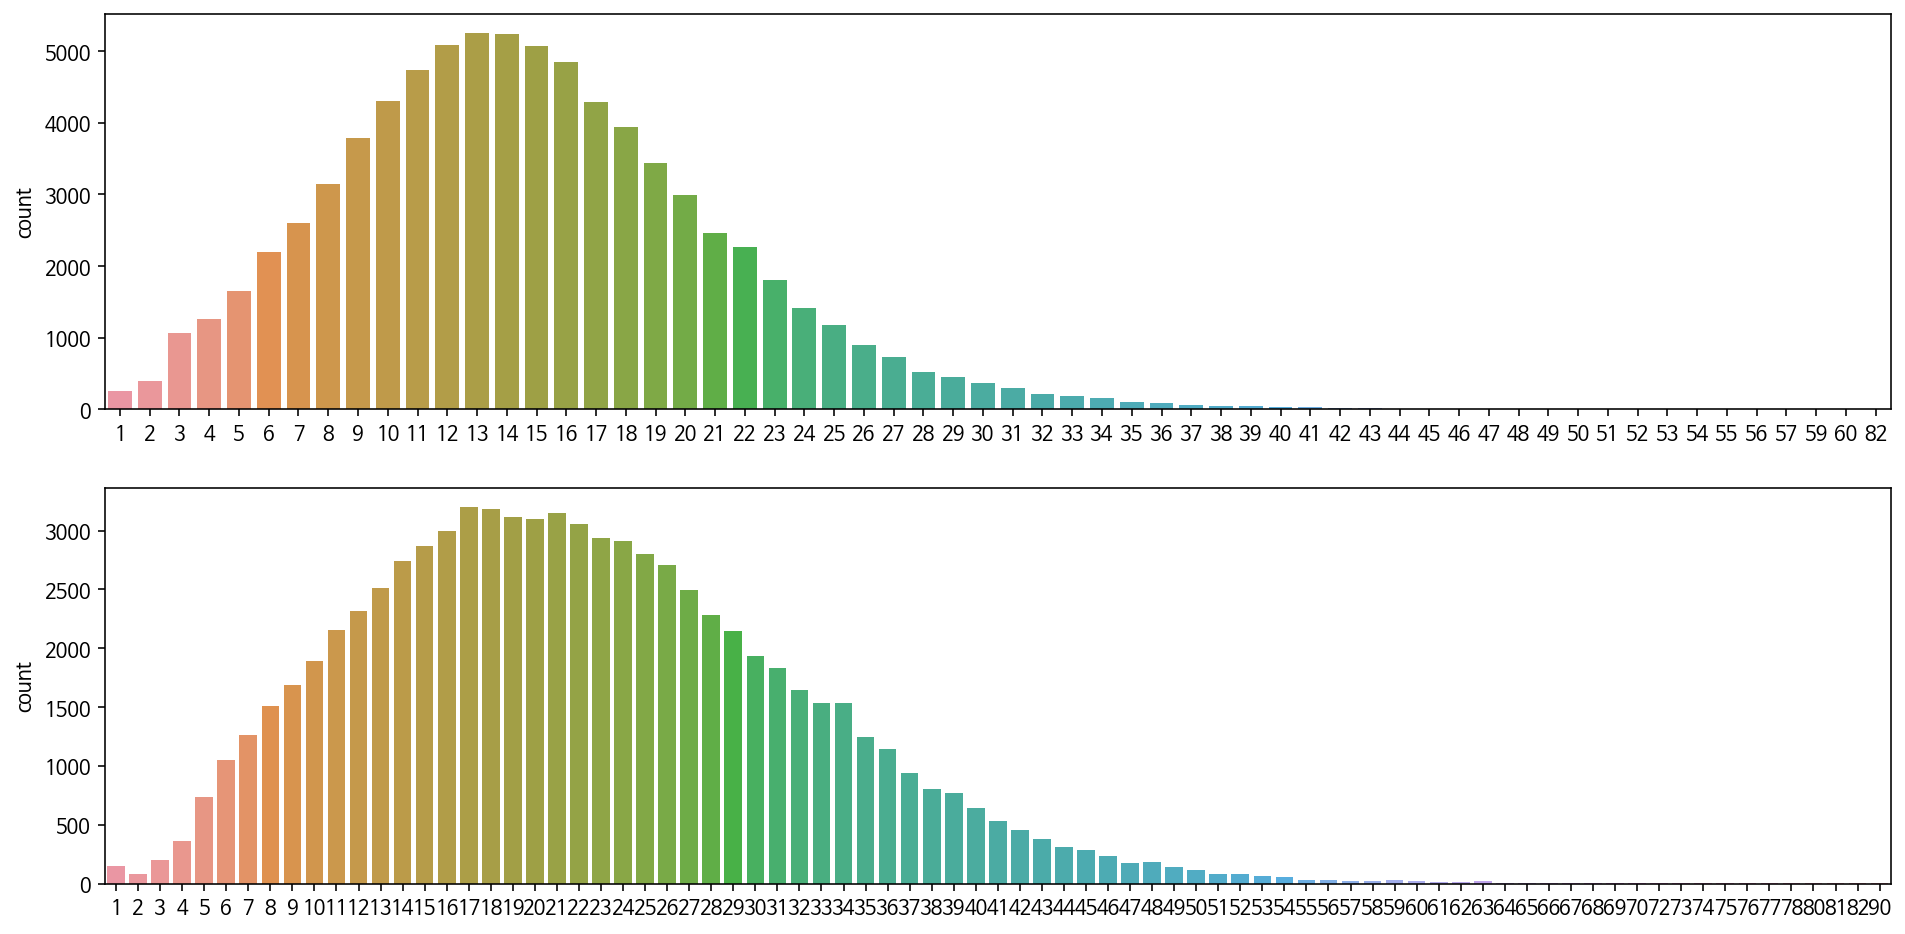

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(211)
sns.countplot(kor_len)
plt.subplot(212)
sns.countplot(eng_len)
plt.show()

길이 분포를 먼저 확인해봅시다.

겉보기엔 이쁜 데이터인 듯 해보입니다.

In [ ]:
for i in range(15):
    print('>> ', corpus['kor'][i])
    print('>> ', corpus['eng'][i])
    print()

>>  개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>>  Much of personal computing is about "can you top this?"

>>  모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
>>  so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.

>>  그러나 이것은 또한 책상도 필요로 하지 않는다.
>>  Like all optical mice, But it also doesn't need a desk.

>>  79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
>>  uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.

>>  정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
>>  Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.

>>  이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다

앞에서 15개의 데이터를 출력해보자마자 심상치 않은 기운이 느껴집니다.

In [ ]:
for i in range(0, len(corpus), 1000):
    print(f'>> No.{i}', corpus['kor'][i])
    print(f'>> No.{i}', corpus['eng'][i])
    print()

>> No.0 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> No.0 Much of personal computing is about "can you top this?"

>> No.1000 그러나 요즈음에 그러한 이론적 해석이 의문시되고 있다.
>> No.1000 / But these days / that rationale is being questioned.

>> No.2000 우리에게 새로운 세기가 다가옴에따라 우리 자신 또한 새로운 세계의 최전방에 있게 되었습니다.
>> No.2000 As we approach a new century, we also find ourselves on the frontier of a new world.

>> No.3000 그는 2071년에서 2073년의 시간대에 충돌의 위험성이 아직 남아 있다고 말했다.
>> No.3000 He said there was still a risk of collision in the 2071-73 time frame.

>> No.4000 Dataplay도 10대 청소년 시장을 겨냥하여 활발히 움직이고 있다.
>> No.4000 Dataplay is also making a strong play for the teen-age market.

>> No.5000 이러한 정신이 존재한다면 어떠한 부정도 이에 맞설 수는 없게 됩니다.
>> No.5000 When this spirit is present, no wrong can stand against it.

>> No.6000 언론은 경찰이 피해자가 음독자살을 했다고 주장했지만 시위대는 수사결과에 의구심을 나타냈다고 보도했다.
>> No.6000 The state-run China Daily newspaper attributed the rioters¡¯ anger to ¡°officials¡¯ alleged attempt to cover up a murder case. ¡±

>> No.7000 크리스티나 페르난데스

1000개 단위로 끊어서 데이터를 처음부터 끝까지 확인해봤습니다.

전부 세심히 확인해보진 못했지만 대충 봐도 번역이 깔끔한 데이터는 아닌 것으로 보입니다.

In [ ]:
for i in range(5990, 6010):
    print(f'>> No.{i}', corpus['kor'][i])
    print(f'>> No.{i}', corpus['eng'][i])
    print()

>> No.5990 브래드 피트와 안젤리나 졸리의 쌍둥이가 머지 않아 태어날 것으로 보인다.
>> No.5990 PARIS, France (CNN) Brangelina's twins aren't here yet, but the big day is drawing closer.

>> No.5991 프랑스 남부 니스 해안에 위치한 람발 병원 관계자는 1일(현지시간) 안젤리나 졸리가 산타마리아 산부인과 병원에 입원, 안정을 취하고 있다고 밝혔다.
>> No.5991 The seafront Lenval hospital in Nice in the south of France said Tuesday that Angelina Jolie had checked in at its Santa Maria maternity clinic to be kept under doctors' surveillance and get some rest before she gives birth.

>> No.5992 네이딘 바우어 병원 대변인은 “오래전부터 계획된 입원이었다”며 “졸리는 매우 건강하다”고 말했다.
>> No.5992 It's been planned for a long time," said Nadine Bauer, a hospital spokeswoman. "She's very well. Everything is fine.

>> No.5993 또한 졸리의 출산이 임박하지는 않았다고 덧붙였다.
>> No.5993 "She is not on the verge of giving birth, not at all," she said.

>> No.5994 대변인은 졸리가 출산 때까지 병원에 있을 예정이라고 밝혔다.
>> No.5994 The 33-year-old actress will almost certainly remain in the hospital until she gives birth, Bauer said.

>> No.5995 그러나 정확한 입원일은 언급하지 않았다.
>> No.59

번역이 고르지 못한 문제를 찾기 위해 번역이 틀린 문장의 주변 문장들을 살펴봤습니다.

문제가 조금 보이긴 하는데 규칙성이나 해결할 방법은 보이지 않습니다.

In [ ]:
for i in range(9990, 10010):
    print(f'>> No.{i}', corpus['kor'][i])
    print(f'>> No.{i}', corpus['eng'][i])
    print()

>> No.9990 이에따라 오바마가 슈퍼대의원 확보 수에서 클린턴에 4명 앞섰다.
>> No.9990 Tom Allen of Maine, Dolly Strazar of Hawaii, Sen. Daniel Akaka of Hawaii and Keith Roark of Idaho all endorsed Obama Monday, giving him a lead of four superdelegates for the time being.

>> No.9991 오바마와 클린턴이 13일(현지시간) 실시되는 웨스트버지니아 경선에서 맞붙는 가운데 여론조사 결과 클린턴이 이곳에서 40% 이상 앞섰다.
>> No.9991 Obama and Clinton face off Tuesday in West Virginia, where polls show Clinton ahead by more than a 40-point margin.

>> No.9992 사퇴 압력을 받고 있는 클린턴을 웨스트버지니아 경선 승리를 바탕으로 역전의 발판을 마련하겠다고 주장했지만 여기에 걸려있는 대의원 수는 28명에 불과하다.
>> No.9992 Under pressure from some to withdraw from the race, Clinton insists that West Virginina, where only 28 delegates are at stake, is a key state in the fight for the White House.

>> No.9993 클린턴은 12일 1916년 이래로 웨스트버지니아 경선에서 패한 후 대통령이 된 민주당 후보는 없는 점을 강조했다.
>> No.9993 She said again Monday that no Democratic candidate since 1916 has gone on to win the White House without first winning West Virginia.

>> No.9994 그는 이날 웨스트버지니아 클리어포크에서 열

다른 곳을 살펴봐도 마찬가지입니다.

In [ ]:
corpus['kor_len'] = corpus['kor'].apply(lambda x: len(x.split()))
corpus['eng_len'] = corpus['eng'].apply(lambda x: len(x.split()))
corpus['dis_len'] = abs(corpus['kor_len'] - corpus['eng_len'])

corpus

,kor,eng,kor_len,eng_len,dis_len
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t...",9,10,1
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...,14,19,5
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee...",7,11,4
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...,21,18,3
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...,29,38,9
...,...,...,...,...,...
78963,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...,20,33,13
78964,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si...",11,20,9
78965,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...,7,16,9
78966,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.,8,8,0


첫 번째 가설입니다.

아무리 다른 언어라 해도 서로의 문장 길이는 얼추 비슷할 것입니다,

만약 그 차이가 크면 번역에 문제가 있는 데이터라고 보겠습니다.

In [ ]:
corpus['dis_len'].describe()

count    78968.000000
mean         8.013638
std          6.313830
min          0.000000
25%          3.000000
50%          7.000000
75%         11.000000
max         63.000000
Name: dis_len, dtype: float64

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


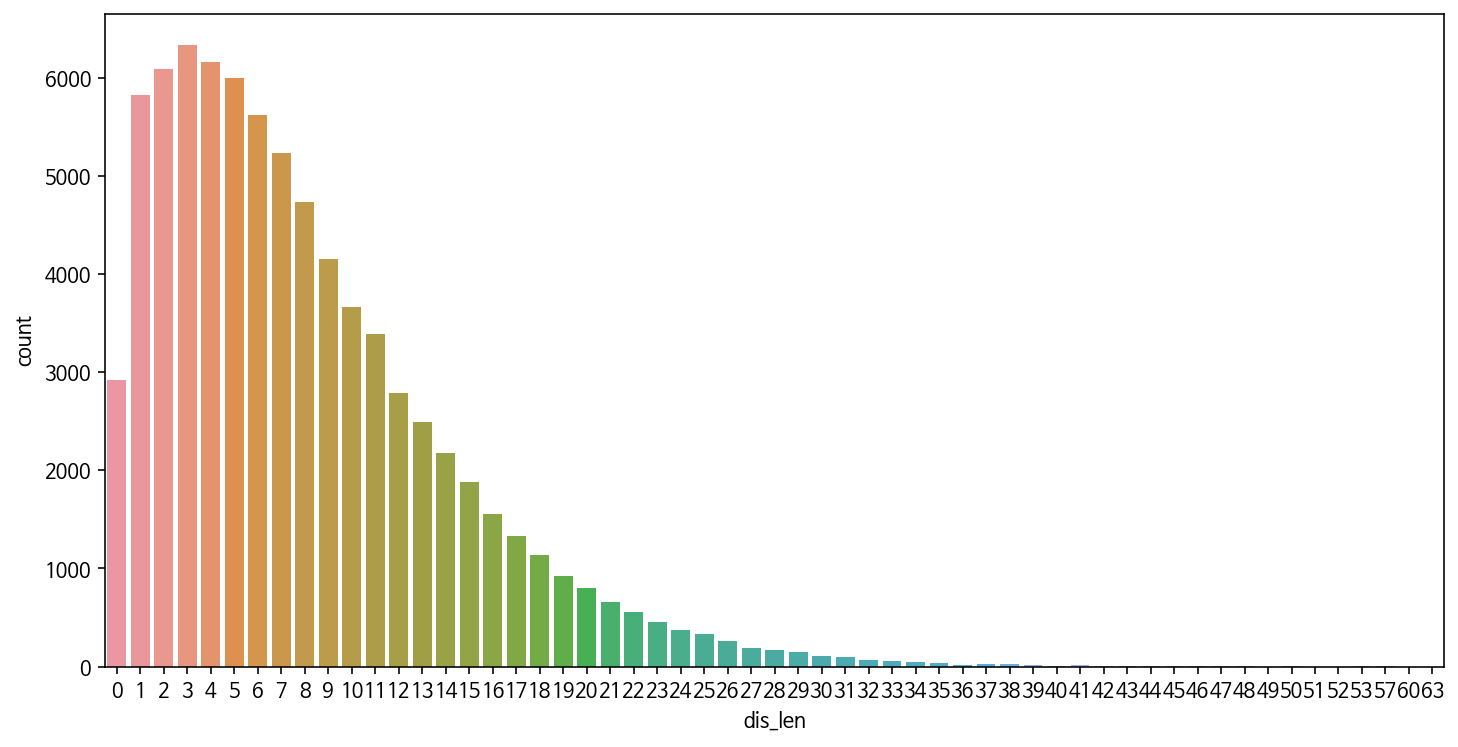

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(corpus['dis_len'])
plt.show()

In [ ]:
corpus.loc[corpus['dis_len'] > 20]

,kor,eng,kor_len,eng_len,dis_len
27,어휘 :,"The Geneva-based commission, in its annual stu...",2,28,26
30,어휘 :,Postal Service - whose postmaster told a Senat...,2,34,32
73,잇따른 토네이도에 의해 36명의 사망자 발생,Emergency workers and stunned residents across...,6,32,26
95,핵무기 개발 완료를 공식 발표한 북한,"The studio later retracted the statement, sayi...",6,32,26
124,국토안보부 신설 법안에 서명한 부시 부시 대통령이 내각 수준의 국토안보부를 신설하는...,Findings from an inquiry by the House-Senate J...,25,56,31
...,...,...,...,...,...
78834,정치 전문가들은 이번 선거에 4가지의 가능성을 점치는데 특히 주요 관심거리는 중도좌...,Political analysts say there is a high chance ...,16,47,31
78841,Japanese rightist group to head for Dokdo 일본 극...,"The Korea Herald reports, in his keynote speec...",12,40,28
78884,Former President Kim Dae-jung hints at NK envo...,Former President Kim Dae-jung on Wednesday exp...,14,38,24
78886,서울 김대중도서관에서 열린 열린우리당 의장과의 회담에서 김 전 대통령은 대북특사 역...,The Korea Times reports that during the meetin...,20,50,30


분포를 참고하여 길이의 차이가 20 이상인 데이터들을 살펴봤습니다.

`어휘: `로 끝나는 한글 문장 등. 아까보다 확실히 데이터의 문제에 규칙성이 드러나기 시작합니다.

In [ ]:
print(corpus['kor'][73])
print(corpus['eng'][73])

잇따른 토네이도에 의해 36명의 사망자 발생
Emergency workers and stunned residents across the South and Great Lakes regions picked through shattered homes and buildings after a string of tornadoes left at least 36 people dead and dozens injured.


겉보기엔 평범해 보이는 문장도 살펴보면 번역에 문제가 있는 데이터입니다.

제거해주겠습니다.

In [ ]:
corpus = corpus.loc[corpus['dis_len'] <= 20]

corpus

,kor,eng,kor_len,eng_len,dis_len
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t...",9,10,1
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...,14,19,5
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee...",7,11,4
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...,21,18,3
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...,29,38,9
...,...,...,...,...,...
78963,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...,20,33,13
78964,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si...",11,20,9
78965,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...,7,16,9
78966,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.,8,8,0


In [ ]:
corpus.loc[corpus['kor'].apply(lambda x: '어휘 :' in x)]

,kor,eng,kor_len,eng_len,dis_len
318,"어휘 : examine 면밀히 조사하다 plight 상태, 양상 revive...","In our Focus report, Bob Dody examines the pli...",10,22,12
773,어휘 : psychologist 심리학자 tactful 재치있는 no les...,"Kenneth Gergen, a Swarthmore College professor...",24,17,7
1064,"어휘 : in general 일반적으로 even 훨씬, 더욱 interest...",Government in general is even less interesting.,12,7,5
1456,어휘 :,aid groups set up freshwater tanks to provide ...,2,11,9
4404,"어휘 : concern 우려, 걱정 / unprecedented 전례 없는 / ...",unprecedented control of access lines by high-...,33,17,16
4758,어휘 :,still experimental but expected to win approva...,2,10,8
5218,어휘 :,It was approved over the weekend by a U.N. pan...,2,19,17
5346,어휘 :,"such as mobile phones, wireless messaging unit...",2,19,17
5494,어휘 :,shortly after the captain reported a fire in t...,2,16,14
5514,어휘 :,"Tech stocks led the way, and there are high ho...",2,20,18


`어휘: `가 있는 오류 데이터도 제거해주겠습니다.

In [ ]:
corpus = corpus.loc[corpus['kor'].apply(lambda x: '어휘 :' not in x)]

corpus

,kor,eng,kor_len,eng_len,dis_len
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t...",9,10,1
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...,14,19,5
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee...",7,11,4
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...,21,18,3
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...,29,38,9
...,...,...,...,...,...
78963,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...,20,33,13
78964,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si...",11,20,9
78965,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...,7,16,9
78966,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.,8,8,0


In [ ]:
corpus.loc[corpus['eng'].apply(lambda x: '#' in x)]

,kor,eng,kor_len,eng_len,dis_len
5996,여중생 변사사건에 대한 경찰의 조사를 못 믿겠다며 시민들이 소요를 벌이자 1일(현지...,"BEIJING, China (CNN) &#8212; Authorities in so...",19,31,12
6011,영국 사람들은 자신들이 좋아하는 대중적인 요리인 ‘피쉬 앤 칩스(fish and c...,"British people love pubs &#8212; so much, in f...",20,25,5
6013,"최근 조사에따르면 영국의 술집 대부분이 실내금연, 세금 및 식료품 가격 인상 등 시...",Recent surveys found that more British pubs ar...,21,27,6
6015,영국의 찰스 왕세자가 38년 된 자신의 애스톤 마틴을 와인으로 만드는 친환경 연료로...,"LONDON, England (CNN) &#8212; Britain¡¯s Princ...",20,25,5
6018,뉴욕 브룩클린에 위치한 병원 대기실에서 49세의 여성이 쓰러진 채 숨져 있었으나 1...,NEW YORK (CNN) &#8212; A 49-year-old woman col...,22,23,1
...,...,...,...,...,...
47860,##http://article.joins.com/article/cnn_e/artic...,##http://article.joins.com/article/cnn_e/artic...,1,2,1
47990,브리트니 스피어스(25)가 20일(현지시간) 재활시설에 입소했다.,##http://article.joins.com/article/cnn_e/artic...,5,1,4
47997,영국 병력은 이라크에서 철수할 예정으로 전해졌다.,##http://article.joins.com/article/cnn_e/artic...,6,1,5
48137,미국 백악관은 18일(현지시간) 이라크전이 미 역사상 '최악의 대외정책 실수'라는 ...,##http://article.joins.com/article/cnn_e/artic...,17,27,10


번역 문장에 `#`이 들어가는 문장도 이상해보여서 확인해봤습니다.

여지없이 제거하도록 하겠습니다.

In [ ]:
corpus = corpus.loc[corpus['eng'].apply(lambda x: '#' not in x)]

corpus

,kor,eng,kor_len,eng_len,dis_len
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t...",9,10,1
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...,14,19,5
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee...",7,11,4
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...,21,18,3
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...,29,38,9
...,...,...,...,...,...
78963,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...,20,33,13
78964,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si...",11,20,9
78965,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...,7,16,9
78966,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.,8,8,0


In [ ]:
corpus.loc[corpus['kor_len'] <= 2]

,kor,eng,kor_len,eng_len,dis_len
529,낙태는 불법이다.,Abortion is illegal.,2,3,1
952,디즈니사만이 아니다.,Disney is not alone.,2,4,2
1174,유럽에서도 마찬가지이다.,The same holds true for Europe.,2,6,4
1615,이것이 사실일까요?,Can any of this be true?,2,6,4
2840,오차범위는 없었다.,No margin of error was given.,2,6,4
...,...,...,...,...,...
78137,영어사전,'' The next round of talks,1,6,5
78352,Korea사전,A South Korean hostage in Iraq has appeared on...,1,14,13
78574,일어사전,Sovereign sold its 7 percent stake in LG Corp.,1,9,8
78629,국어사전,"The Korea Herald reports Wal-Mart Korea, the l...",1,13,12


In [ ]:
corpus.loc[corpus['eng_len'] <= 4]

,kor,eng,kor_len,eng_len,dis_len
133,선례가 하나 있다.,There is a precedent.,3,4,1
155,"그것은 큰 문제입니다.""","""It's a big problem.""",3,4,1
462,난 롱 죤 액티브라구.,I'm Long John Active.,4,4,0
483,"그게 우리의 강점이죠.""","That's our strength.""",3,3,0
529,낙태는 불법이다.,Abortion is illegal.,2,3,1
...,...,...,...,...,...
78465,"irresponsibility 무책임, 책임을 지지 않음",“The height of irresponsibility;,5,4,1
78580,"본프레레, 결국 사퇴 2005.10",Bonfrere quits football coach.,4,4,0
78704,워싱턴에서 에드 도나휴였습니다.”,"Ed Donahue, Washington.”",3,3,0
78926,"잘 알겠습니다, 워렌 기자.","Okay, thank you, Warren.",4,4,0


길이가 짧은 문장도 살펴봤습니다.

두 번째 가설입니다.

한글이 영어에 비해 통계적으로 길이가 더 짧은 것을 알 수 있는데,

그에 반해 한글 문장의 길이가 영어 문장의 길이보다 두 배 이상 많을 경우 번역에 오류가 있는 데이터라고 가정하겠습니다.

In [ ]:
corpus.loc[corpus['kor_len'] >= corpus['eng_len']*2]

,kor,eng,kor_len,eng_len,dis_len
17,과거 노조 지도자였던 루이스 이나시오 룰라 다 실바가 브라질의 대통령 선거 결선 투...,marking a historic shift to the left for Latin...,24,12,12
74,70개 이상의 토네이도가 덮친 이후에 알라바마州에서 펜실바니아州에 이르는 지역에서 ...,after more than 70 tornadoes touched down.,16,7,9
78,적당한 육체 활동이 심장 질환을 예방하는 데 좋지만 활동의 정도를 높이는 것이 더욱...,"especially if combined with weight-training, a...",34,14,20
319,"최근 워싱턴에서 한 겨울 에 열렸던 미국 시장 회의를 겨냥하여, 미 상원의원인 폴 ...","Conference of Mayors in Washington, U.S.",22,6,16
366,"(날씨가 좋았기 때문에 그들은 하이킹을 갔다.) = As it was fine, t...","It being fine, they went hiking.",14,6,8
...,...,...,...,...,...
78343,런던 주재 중국 대사가 서방 언론이 중국을 악마로 만들고 있다고 비난하고 티베트에는...,"""""Where is the gentleman ship?",16,5,11
78392,경찰들이 교통 마비 상태의 완화를 위해 대거 투입되면서 농민소유 차량의 창문들을 부...,More than 300 arrests were made.,17,6,11
78578,두바이에 본사를 둔 소버린자산운용은 LG 지분을 마지막으로 한국에 더 이상 투자를 ...,The LG stocks were the last of the investment ...,36,17,19
78674,"남북한은 지난 목요일, 양국 정상간의 최근 정상 회담에서 합의된 경제 협력 프로젝트...",as part of economic cooperation projects agree...,27,13,14


제거해도 좋을 것 같습니다.

In [ ]:
corpus = corpus.loc[corpus['kor_len'] < corpus['eng_len']*2]

corpus

,kor,eng,kor_len,eng_len,dis_len
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t...",9,10,1
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...,14,19,5
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee...",7,11,4
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...,21,18,3
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...,29,38,9
...,...,...,...,...,...
78963,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...,20,33,13
78964,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si...",11,20,9
78965,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...,7,16,9
78966,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.,8,8,0


In [ ]:
corpus.loc[corpus['kor_len']*3 <= corpus['eng_len']]

,kor,eng,kor_len,eng_len,dis_len
22,100여명의 사망자가 예상되는 베트남 빌딩 화재,At least 54 people have been confirmed dead bu...,6,19,13
159,베트남의 호치민시를 방문한 클린턴,President Bill Clinton arrived in Ho Chi Minh ...,4,20,16
565,"""난 크리스마스에 덴버 공항에 있었습니다.","""I was in the Denver airport on Christmas Day ...",5,19,14
1129,질량압축무리물체라고 부르는 일상적인 물질이라는 강력한 증거를 제시했습니다.,"Stromlo Observatory near Canberra, Australia, ...",7,22,15
1174,유럽에서도 마찬가지이다.,The same holds true for Europe.,2,6,4
...,...,...,...,...,...
78836,"back down 후퇴, 철회","On Tuesday, Lee and Park made it clear they wi...",4,17,13
78867,tax relief 세금 공제,“ It provides tax relief for 95% of Americans ...,4,15,11
78869,TOEIC 독해,The vote is expected late today.,2,6,4
78883,"veto (일반적으로) 거부, 금지(prohibition); 금지권",The agreement came after China lifted its obje...,5,19,14


비슷하게 한글 문장의 길이보다 영어 문장의 길이가 비정상적으로 긴 데이터도 확인해봤습니다.

제거하도록 하겠습니다.

In [ ]:
corpus = corpus.loc[corpus['kor_len']*3 > corpus['eng_len']]

corpus

,kor,eng,kor_len,eng_len,dis_len
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t...",9,10,1
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...,14,19,5
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee...",7,11,4
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...,21,18,3
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...,29,38,9
...,...,...,...,...,...
78963,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...,20,33,13
78964,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si...",11,20,9
78965,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...,7,16,9
78966,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.,8,8,0


In [ ]:
corpus.loc[corpus['kor'].apply(lambda x: '사전' in x)]

,kor,eng,kor_len,eng_len,dis_len
1659,"그것은 우리에게 호환성을 제공한다."" Toshiba 아메리카 지사의 부사장 히로유끼...","Hiroyuki Furukawa, a vice president of Toshiba...",27,22,5
4522,캘리포니아州 가든 그로브에 본사가 있는 소기업인 Hop-On는 이번 주에 자사의 첫...,"Hop-On, a small company based in Garden Grove,...",35,39,4
6956,그러나 미 식품의약국의 데이비드 애치슨 박사는 18일 보고서에서 새로 감염된 사례가...,The increase reported Wednesday resulted not f...,36,51,15
7804,마이클 철토프 DHS 장관은 오는 8월 1일부터 인터넷 사이트를 통한 사전등록 접수...,DHS will begin accepting applications via a se...,25,31,6
7977,사전 사망자 집계가 이번 사건처럼 다양한 것이 드물다.,It is not uncommon for preliminary casualty fi...,8,10,2
...,...,...,...,...,...
72999,영한사전 약어표 / 한영사전 약어표,Korean animal rights activists ?,5,5,0
73967,영한사전 약어표 / 한영사전 약어표,"Two officers sustained fatal gunshot wounds, a...",5,14,9
76001,영한사전 약어표 / 한영사전 약어표,President George W. Bush tentatively slated fo...,5,13,8
76036,영한사전 약어표 / 한영사전 약어표,The government will communicate with the media...,5,14,9


데이터를 보다보니 한글 문장에 특정 키워드가 반복되는 것이 보여서 확인해봤습니다.

`사전`이라는 단어가 들어가면서 정말 사전을 보는 것처럼 몇 가지 단어만 늘어놓는 데이터가 보입니다.

In [ ]:
corpus.loc[corpus['kor'].apply(lambda x: '사전' in x and len(x.split()) < 6)]

,kor,eng,kor_len,eng_len,dis_len
57815,영한사전 약어표 / 한영사전 약어표,Korean troops have been deployed there since A...,5,9,4
61334,영한사전 약어표 / 한영사전 약어표,"Kwon Jae-yoon and Lee Yoon-gyeong, 18-year-old...",5,13,8
61434,"preview 사전 검토, 프리뷰, 미리보기",The AP's Sophia Manos has a preview:,5,7,2
62218,영한사전 약어표 / 한영사전 약어표,The South Korean ship left port on Sunday nigh...,5,14,9
62541,영한사전 약어표 / 한영사전 약어표,"However, South Koreans who experience wasting ...",5,13,8
68813,영한사전 약어표 / 한영사전 약어표,Koreans would face punishment if they entered ...,5,12,7
70568,영한사전 약어표 / 한영사전 약어표,"U.S. officials refer to the concept as CVID, f...",5,14,9
72999,영한사전 약어표 / 한영사전 약어표,Korean animal rights activists ?,5,5,0
73967,영한사전 약어표 / 한영사전 약어표,"Two officers sustained fatal gunshot wounds, a...",5,14,9
76001,영한사전 약어표 / 한영사전 약어표,President George W. Bush tentatively slated fo...,5,13,8


`사전`이라는 단어가 들어가면서 길이가 짧은 데이터를 검색해봤습니다.

제거하도록 하겠습니다.

In [ ]:
corpus = corpus.loc[corpus['kor'].apply(lambda x: '사전' not in x or len(x.split()) >= 6)]

corpus

,kor,eng,kor_len,eng_len,dis_len
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t...",9,10,1
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...,14,19,5
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee...",7,11,4
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...,21,18,3
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...,29,38,9
...,...,...,...,...,...
78963,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...,20,33,13
78964,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si...",11,20,9
78965,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...,7,16,9
78966,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.,8,8,0


In [ ]:
corpus.loc[corpus['eng'].apply(lambda x: '¡°' in x)]

,kor,eng,kor_len,eng_len,dis_len
5997,신화통신은 시 종위안 현지 관할 공산당 관계자의 말을 인용 “사회적 화합과 안정을 ...,¡°We must put maintaining social harmony and s...,16,27,11
6000,언론은 경찰이 피해자가 음독자살을 했다고 주장했지만 시위대는 수사결과에 의구심을 나...,The state-run China Daily newspaper attributed...,11,20,9
6020,에스민 그린은 지난해 6월 18일 뉴욕 킹 카운티 병원 정신과 응급실에 입원했다.,Esmin Green was involuntarily admitted to the ...,12,27,15
6027,검찰은 사건을 넘겨받은 자료를 신중히 검토해 이를 토대로 좀더 조사할지 종료할지를 ...,Prosecutors said they will now carefully revie...,14,32,18
6030,궁은 성명을 통해 “사르코지 대통령이 이미 언급한대로 사건에 대한 조사를 긴밀히 주...,"¡°The president ¡¦ as he has already stated, i...",14,23,9
...,...,...,...,...,...
17282,그는 “현재까지 황열병에 대한 보고는 원숭이가 죽었다는 것 밖에 없다”며 “이후 황...,"¡°That put us on alert, and we have put in pla...",20,20,0
22968,"백악관은 ""대신 테이프 파기와 관련, 사전 조사를 지원하는데 전념할 것”이라며 “편...",¡°We will instead focus our efforts on support...,21,31,10
46966,콜롬비아 보고타 국립 대학에서는 학생 200명이 “부시 가라”를 외치며 300명의 ...,"¡°At National University in Bogota, Colombia, ...",16,18,2
51667,“집에서 이 기술을 활용할 수 없을까?”,"¡°Why can't I do this at home?""",6,7,1


그리고 `i°`, `¡¦`, `¡¯`, `¡±` 등 이상한 문자가 섞여 있는 데이터가 있습니다.

번역에는 문제가 없어보이니 이 부분은 정규식을 이용해 노이즈 문자만 제거해주겠습니다.

In [ ]:
corpus.loc[corpus['kor'].apply(lambda x: bool(re.match(r'["a-zA-Z"]{5}', x)))]

,kor,eng,kor_len,eng_len,dis_len
162,ICANN의 이번 결정으로 전세계적으로 등록수가 약 2천만이 되는 닷컴으로 끝나는 ...,The decisions by ICANN capped a half-decade of...,20,28,8
181,Kamen은 Segway HT라고 불리는 이 발명품이 앞으로 수 개월 동안은 제한된...,Kamen said the invention - called the Segway H...,21,34,13
186,Amazon.com 창립자이자 CEO인 Jeff Bezos는 이 발명품을 특히 좋아...,Amazon.com founder and CEO Jeff Bezos has take...,14,20,6
187,Ginger에 관한 뉴스는 하버드 경영대 출판부가 한 작가의 도움을 받아 Ginge...,News of Ginger was first uncovered when it was...,26,35,9
188,Kamen의 작업은 New Hampshire 州 Manchester의 DEKA 연구...,"Kamen's work is based out of a Manchester, New...",13,16,3
...,...,...,...,...,...
78868,Unemployment rate expected to get even worse 실...,“Democrats have the numbers to pass the measur...,13,17,4
78896,Obama defends decision to close Guantanamo pri...,A strong defense of the decision to close down...,15,26,11
78904,First US trial planned for Gitmo detainee 관타나모...,“ It serves as a recruitment tool for terroris...,16,29,13
78905,Malicious program makers have been prosecuted ...,"It is they first time makers of so-called """"sp...",17,16,1


한글 문장에 알파벳이 5개 이상 포함되는 데이터를 확인해봤습니다.

일부 데이터는 사람 이름 때문에 어쩔 수 없다고는 해도 제거해주겠습니다.

In [ ]:
corpus = corpus.loc[corpus['kor'].apply(lambda x: not bool(re.match(r'["a-zA-Z"]{5}', x)))]

corpus

,kor,eng,kor_len,eng_len,dis_len
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t...",9,10,1
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...,14,19,5
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee...",7,11,4
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...,21,18,3
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...,29,38,9
...,...,...,...,...,...
78963,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...,20,33,13
78964,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si...",11,20,9
78965,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...,7,16,9
78966,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.,8,8,0


문제가 있는 데이터 제거는 여기서 마무리하고 다시 데이터를 1천 개 단위로 확인해보겠습니다.

In [ ]:
corpus = corpus.reset_index(drop=True)

for i in range(0, len(corpus), 1000):
    print(f'>> No.{i}', corpus['kor'][i])
    print(f'>> No.{i}', corpus['eng'][i])
    print()

>> No.0 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> No.0 Much of personal computing is about "can you top this?"

>> No.1000 서구인들은 아직도 종종 그 지역을 일본의 뒷마당이나 엔 블록의 일부라고 언급하고 있다.
>> No.1000 Westerners still often refer to the area as Japan's backyard or part of the yen block.

>> No.2000 교황 요한 바오르 2세는 교황청이 강력하게 반대하는 대이라크 전쟁이 일어날 지도 모르는 상황에서 수요일 일찍 크리스마스 이브 미사를 축하했다.
>> No.2000 VATICAN CITY (AP) _ Pope John Paul II celebrated Christmas Eve Mass early Wednesday against the backdrop of a possible war against Iraq _ a war to which the Vatican is voicing increasing opposition.

>> No.3000 지난 여러해 동안에 우리는 첨단기술 분야의 유명 인사들이 빠르게 모은 엄청난 재산의 양에 대해 이야기를 들어왔다.
>> No.3000 For the past several years we have been hearing about the gargantuan amounts of wealth rapidly accumulated by tech superstars.

>> No.4000 영진은 일본에 부역하거나 결탁한 모든 사람을 공격하며 시골 고향을 배회한다.
>> No.4000 Young-jin runs around his rural hometown, attacking all those who work or collude with the Japanese.

>> No.5000 (그것을 하지 말라고 누차 경고하지 않았나.) 따분하고 핵의 기운이

이 정도면 충분히 제거된 것 같으니 특수문자들을 제거해주겠습니다.

In [ ]:
def preprocess_sentence(sentence, token=False):
    sentence = sentence.lower().strip()
    
    sentence = re.sub(r"['¡°¡¦¡¯¡±]", "", sentence) # 노이즈 문자 제거
    sentence = re.sub(r"([#*+-/:;<=>@\[\]\"^_`{|}~])", "", sentence) # 특수문자 제거(일부 예외 처리함)
    sentence = re.sub(r"([$%&()?!',.])", r" \1 ", sentence) # 예외 처리한 특수문자들 주변에 공백 추가)
    sentence = re.sub(r"[' ']+", " ", sentence) # 여러 개의 공백은 하나의 공백으로

    sentence = sentence.strip()

    if token:
        sentence = '<start> ' + sentence + ' <end>'
    
    return sentence

함수는 `¡°`같은 노이즈 문자를 제거하는 것을 중점에 뒀습니다.

In [ ]:
for i in range(15):
    print('>> ', preprocess_sentence(corpus['kor'][i]))
    print('>> ', preprocess_sentence(corpus['eng'][i], token=True))
    print()

>>  개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?
>>  <start> much of personal computing is about can you top this ? <end>

>>  모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다
>>  <start> so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable wireless mouse <end>

>>  그러나 이것은 또한 책상도 필요로 하지 않는다
>>  <start> like all optical mice but it also doesnt need a desk <end>

>>  7995달러하는 이 최첨단 무선 광마우스는 허공에서 팔목 팔 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다
>>  <start> uses gyroscopic sensors to control the cursor movement as you move your wrist arm whatever through the air <end>

>>  정보 관리들은 동남 아시아에서의 선박들에 대한 많은 ( 테러 ) 계획들이 실패로 돌아갔음을 밝혔으며 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다
>>  <start> intelligence officials have revealed a spate of foiled plots on ships in southeast asia and are warning that a narrow stretch of water carrying almost one third of the worlds maritime trade is vulnerable to a terror attack <end>

>>  이 

In [ ]:
corpus['kor'] = corpus['kor'].apply(preprocess_sentence)
corpus['eng'] = corpus['eng'].apply(preprocess_sentence, token=True)

In [ ]:
from konlpy.tag import Mecab

corpus['kor'] = corpus['kor'].apply(Mecab().morphs)
corpus['eng'] = corpus['eng'].apply(lambda x: x.split())

corpus

,kor,eng,kor_len,eng_len,dis_len
0,"[개인, 용, 컴퓨터, 사용, 의, 상당, 부분, 은, 이것, 보다, 뛰어날, 수,...","[<start>, much, of, personal, computing, is, a...",9,10,1
1,"[모든, 광, 마우스, 와, 마찬가지, 로, 이, 광, 마우스, 도, 책상, 위, ...","[<start>, so, a, mention, a, few, weeks, ago, ...",14,19,5
2,"[그러나, 이것, 은, 또한, 책상, 도, 필요, 로, 하, 지, 않, 는다]","[<start>, like, all, optical, mice, but, it, a...",7,11,4
3,"[7995, 달러, 하, 는, 이, 최첨단, 무선, 광, 마우스, 는, 허공, 에서...","[<start>, uses, gyroscopic, sensors, to, contr...",21,18,3
4,"[정보, 관리, 들, 은, 동남, 아시아, 에서, 의, 선박, 들, 에, 대한, 많...","[<start>, intelligence, officials, have, revea...",29,38,9
...,...,...,...,...,...
71271,"[“, 우리, 는, 3, 월, 8, 일, 김승연, 회장, 과, 그, 의, 아들, 이...","[<start>, ””we, are, hoping, to, seize, materi...",20,33,13
71272,"[월요일, 술집, 종업원, 6, 명, 은, 김, 회장, 과, 아들, 에게, 폭행, ...","[<start>, ”, on, monday, police, secured, stat...",11,20,9
71273,"[그러나, 불, 충분, 한, 증거, 확보, 로, 수사, 에, 어려움, 이, 있, 다]","[<start>, but, the, lack, of, material, eviden...",7,16,9
71274,"[김, 회장, 과, 그, 의, 아들, 은, 보복, 폭행, 혐의, 를, 강력히, 부인...","[<start>, kim, and, his, son, both, deny, the,...",8,8,0


한글 문장은 KoNLPy의 Mecab으로 형태소 분리를 해줬고, 영어 문장은 공백을 기준으로 분리해줬습니다.

In [ ]:
kor_len = [len(i) for i in corpus['kor']]
eng_len = [len(i) for i in corpus['eng']]

print('한글 데이터의 최장 길이 :', max(kor_len))
print('한글 데이터의 평균 길이 :', sum(kor_len)/len(kor_len))
print('영어 데이터의 최장 길이 :', max(eng_len))
print('영어 데이터의 평균 길이 :', sum(eng_len)/len(eng_len))

한글 데이터의 최장 길이 : 119
한글 데이터의 평균 길이 : 29.481943431168975
영어 데이터의 최장 길이 : 70
영어 데이터의 평균 길이 : 23.60105785958808


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


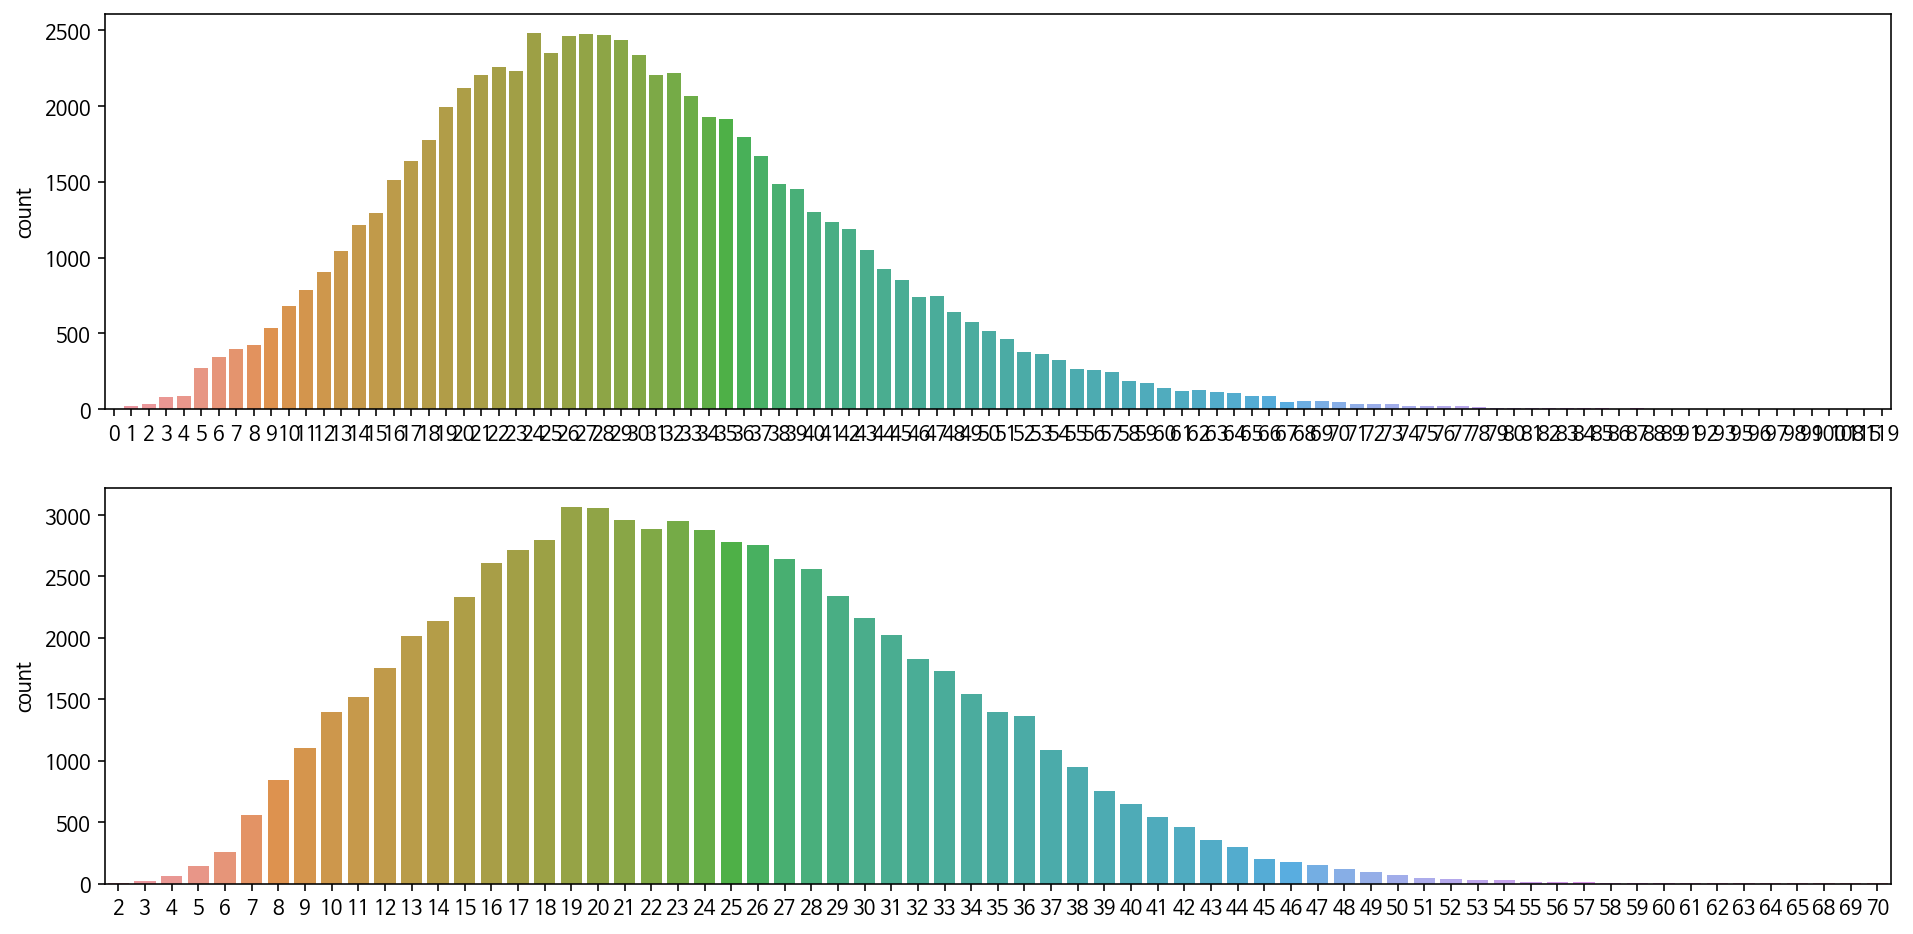

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(211)
sns.countplot(kor_len)
plt.subplot(212)
sns.countplot(eng_len)
plt.show()

토큰화 후 길이 분포입니다.

In [ ]:
kor_min_len = 4
kor_max_len = 50
eng_min_len = 6
eng_max_len = 40

corpus = corpus[corpus['kor'].apply(lambda x: kor_min_len < len(x) < kor_max_len)]
corpus = corpus[corpus['eng'].apply(lambda x: eng_min_len < len(x) < eng_max_len)]

corpus

,kor,eng,kor_len,eng_len,dis_len
0,"[개인, 용, 컴퓨터, 사용, 의, 상당, 부분, 은, 이것, 보다, 뛰어날, 수,...","[<start>, much, of, personal, computing, is, a...",9,10,1
1,"[모든, 광, 마우스, 와, 마찬가지, 로, 이, 광, 마우스, 도, 책상, 위, ...","[<start>, so, a, mention, a, few, weeks, ago, ...",14,19,5
2,"[그러나, 이것, 은, 또한, 책상, 도, 필요, 로, 하, 지, 않, 는다]","[<start>, like, all, optical, mice, but, it, a...",7,11,4
3,"[7995, 달러, 하, 는, 이, 최첨단, 무선, 광, 마우스, 는, 허공, 에서...","[<start>, uses, gyroscopic, sensors, to, contr...",21,18,3
7,"[이, 보고서, 에, 따르, 면, 특히, 군사, 작전, 에서, 생사, 가, 걸린, ...","[<start>, specifically, it, can, be, used, in,...",26,30,4
...,...,...,...,...,...
71271,"[“, 우리, 는, 3, 월, 8, 일, 김승연, 회장, 과, 그, 의, 아들, 이...","[<start>, ””we, are, hoping, to, seize, materi...",20,33,13
71272,"[월요일, 술집, 종업원, 6, 명, 은, 김, 회장, 과, 아들, 에게, 폭행, ...","[<start>, ”, on, monday, police, secured, stat...",11,20,9
71273,"[그러나, 불, 충분, 한, 증거, 확보, 로, 수사, 에, 어려움, 이, 있, 다]","[<start>, but, the, lack, of, material, eviden...",7,16,9
71274,"[김, 회장, 과, 그, 의, 아들, 은, 보복, 폭행, 혐의, 를, 강력히, 부인...","[<start>, kim, and, his, son, both, deny, the,...",8,8,0


한글 데이터의 최장 길이 : 49
한글 데이터의 평균 길이 : 27.454428853999257
영어 데이터의 최장 길이 : 39
영어 데이터의 평균 길이 : 22.39927679564841


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


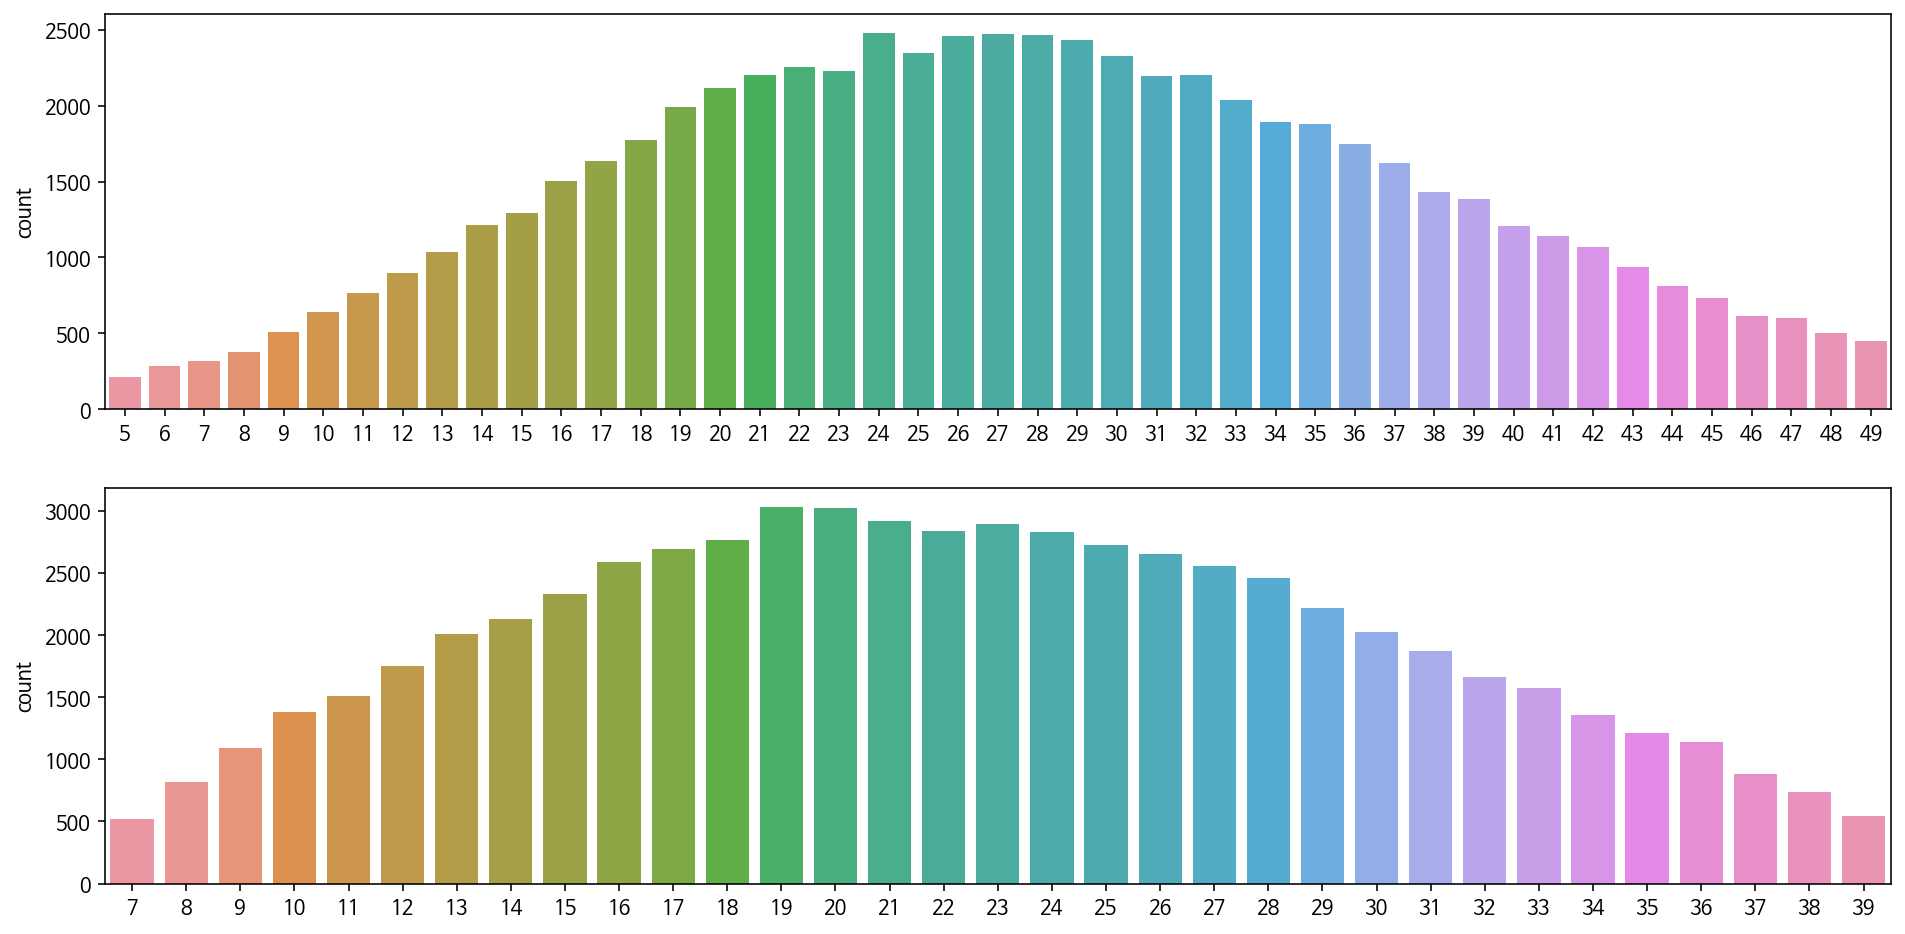

In [ ]:
kor_len = [len(i) for i in corpus['kor']]
eng_len = [len(i) for i in corpus['eng']]

print('한글 데이터의 최장 길이 :', max(kor_len))
print('한글 데이터의 평균 길이 :', sum(kor_len)/len(kor_len))
print('영어 데이터의 최장 길이 :', max(eng_len))
print('영어 데이터의 평균 길이 :', sum(eng_len)/len(eng_len))

plt.figure(figsize=(16, 8))
plt.subplot(211)
sns.countplot(kor_len)
plt.subplot(212)
sns.countplot(eng_len)
plt.show()

그래프를 참고해서 한글은 5이상 49이하의 길이를 가진 문장만,

영어는 7이상 39이하의 길이를 가진 문장만 남겨줬습니다.

In [ ]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=' ', num_words=20000)
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

enc_train, enc_tokenizer = tokenize(corpus['kor'])
dec_train, dec_tokenizer = tokenize(corpus['eng'])

for i in range(5):
    print(enc_train[i])
    print(dec_train[i])
    print()

[ 696  632  548  182    5 1422  873    6  739  165   42   12 3639  520
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]
[   2  263    5 1286 8470   13   41   97   98  196   39  273    3    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]

[  226  5273  6145    31  2685    19     2  5273  6145    38  7166   229
     7   719     3  6145 17958     8   256    19    10    30    43   461
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
[    2   142     6  3982     6   360   280   256    41     6 15435  3399
 17920  6368   961     7   167 15435  3399  6368     3     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]

[  87  739

In [ ]:
print("English Vocab Size:", len(enc_tokenizer.index_word))
print("Spanish Vocab Size:", len(dec_tokenizer.index_word))

English Vocab Size: 46893
Spanish Vocab Size: 52731


- - -
### 모델 설계하기

#### *어텐션*

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

#### *인코더*

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

#### *디코더*

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.dropout = tf.keras.layers.Dropout(0.2)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.dropout(out)
        out = self.fc(out)

        return out, h_dec, attn

In [ ]:
# 코드를 실행하세요.

BATCH_SIZE     = 16
SRC_VOCAB_SIZE = 20000
TGT_VOCAB_SIZE = 20000

units         = 256
embedding_dim = 1024

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (16, 30, 256)
Decoder Output: (16, 20000)
Decoder Hidden State: (16, 256)
Attention: (16, 30, 1)


배치 사이즈는 16, 히든 유닛은 256, 임베딩 차원 수는 1024로 설정했습니다.

- - -
### 모델 학습하기

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [ ]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [ ]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    sentence = Mecab().morphs(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder, show_attention=False):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    if show_attention:
        attention = attention[:len(result.split()), :len(sentence)]
        plot_attention(attention, sentence, result.split(' '))

In [ ]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 15

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm
    
    for example in examples:
        translate(example, encoder, decoder)

Epoch  1: 100%|██████████| 4045/4045 [13:30<00:00,  4.99it/s, Loss 3.8855] 


Input: ['오바마', '는', '대통령', '이', '다']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
Input: ['시민', '들', '은', '도시', '속', '에', '산다']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
Input: ['커피', '는', '필요', '없', '다']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다']
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


Epoch  2: 100%|██████████| 4045/4045 [12:22<00:00,  5.45it/s, Loss 3.7495]


Input: ['오바마', '는', '대통령', '이', '다']
Predicted translation: the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the 
Input: ['시민', '들', '은', '도시', '속', '에', '산다']
Predicted translation: the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the 
Input: ['커피', '는', '필요', '없', '다']
Predicted translation: the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the 
Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다']
Predicted translation: the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the be the 


Epoch  3: 100%|██████████| 4045/4045 [12:25<00:00,  5.43it/s, Loss 3.2719]


Input: ['오바마', '는', '대통령', '이', '다']
Predicted translation: obama <end> 
Input: ['시민', '들', '은', '도시', '속', '에', '산다']
Predicted translation: the associated press <end> 
Input: ['커피', '는', '필요', '없', '다']
Predicted translation: the new york is a lot of the <end> 
Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다']
Predicted translation: the us military official said <end> 


Epoch  4: 100%|██████████| 4045/4045 [12:24<00:00,  5.43it/s, Loss 2.8587]


Input: ['오바마', '는', '대통령', '이', '다']
Predicted translation: obama is the first time <end> 
Input: ['시민', '들', '은', '도시', '속', '에', '산다']
Predicted translation: the people are the most of the country <end> 
Input: ['커피', '는', '필요', '없', '다']
Predicted translation: the study is a good <end> 
Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다']
Predicted translation: the us military was killed in the us <end> 


Epoch  5: 100%|██████████| 4045/4045 [06:47<00:00,  9.94it/s, Loss 2.5962]


Input: ['오바마', '는', '대통령', '이', '다']
Predicted translation: obama is the first africanamerican <end> 
Input: ['시민', '들', '은', '도시', '속', '에', '산다']
Predicted translation: they are being able to be the most dangerous <end> 
Input: ['커피', '는', '필요', '없', '다']
Predicted translation: it is not a good <end> 
Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다']
Predicted translation: the number of the dead were killed in the capital <end> 


Epoch  6: 100%|██████████| 4045/4045 [05:46<00:00, 11.66it/s, Loss 2.4003]


Input: ['오바마', '는', '대통령', '이', '다']
Predicted translation: obama is the first time <end> 
Input: ['시민', '들', '은', '도시', '속', '에', '산다']
Predicted translation: they are going to be the most powerful <end> 
Input: ['커피', '는', '필요', '없', '다']
Predicted translation: the company is not going to be <end> 
Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다']
Predicted translation: the dead were killed in the past week <end> 


Epoch  7: 100%|██████████| 4045/4045 [05:47<00:00, 11.65it/s, Loss 2.2399]


Input: ['오바마', '는', '대통령', '이', '다']
Predicted translation: obama is the first time <end> 
Input: ['시민', '들', '은', '도시', '속', '에', '산다']
Predicted translation: they are more than a day <end> 
Input: ['커피', '는', '필요', '없', '다']
Predicted translation: the company says its not be a good time <end> 
Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다']
Predicted translation: another 23 people died in the same time <end> 


Epoch  8: 100%|██████████| 4045/4045 [05:46<00:00, 11.67it/s, Loss 2.1072]


Input: ['오바마', '는', '대통령', '이', '다']
Predicted translation: obama is the president <end> 
Input: ['시민', '들', '은', '도시', '속', '에', '산다']
Predicted translation: they want people in the town <end> 
Input: ['커피', '는', '필요', '없', '다']
Predicted translation: apple is not easy <end> 
Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다']
Predicted translation: seven people were killed in the same time <end> 


Epoch  9: 100%|██████████| 4045/4045 [05:44<00:00, 11.74it/s, Loss 1.9936]


Input: ['오바마', '는', '대통령', '이', '다']
Predicted translation: obama is the only female <end> 
Input: ['시민', '들', '은', '도시', '속', '에', '산다']
Predicted translation: the children are more than a few miles <end> 
Input: ['커피', '는', '필요', '없', '다']
Predicted translation: apple has not to buy <end> 
Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다']
Predicted translation: seven deaths have died in the country <end> 


Epoch 10: 100%|██████████| 4045/4045 [05:43<00:00, 11.77it/s, Loss 1.8899]


Input: ['오바마', '는', '대통령', '이', '다']
Predicted translation: obama is the only candidate <end> 
Input: ['시민', '들', '은', '도시', '속', '에', '산다']
Predicted translation: they fear the holidays <end> 
Input: ['커피', '는', '필요', '없', '다']
Predicted translation: its not to be <end> 
Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다']
Predicted translation: seven deaths have died in the crossfire <end> 


Epoch 11: 100%|██████████| 4045/4045 [05:43<00:00, 11.76it/s, Loss 1.8082]


Input: ['오바마', '는', '대통령', '이', '다']
Predicted translation: obama is the president <end> 
Input: ['시민', '들', '은', '도시', '속', '에', '산다']
Predicted translation: the children are up in the city <end> 
Input: ['커피', '는', '필요', '없', '다']
Predicted translation: the price is a good <end> 
Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다']
Predicted translation: seven people have died in the same time <end> 


Epoch 12: 100%|██████████| 4045/4045 [05:43<00:00, 11.76it/s, Loss 1.7266]


Input: ['오바마', '는', '대통령', '이', '다']
Predicted translation: obama has also is to be the presidents harlem <end> 
Input: ['시민', '들', '은', '도시', '속', '에', '산다']
Predicted translation: they are more than a stick of the community <end> 
Input: ['커피', '는', '필요', '없', '다']
Predicted translation: apple has no longer <end> 
Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다']
Predicted translation: seven of the dead were killed <end> 


Epoch 13: 100%|██████████| 4045/4045 [05:43<00:00, 11.77it/s, Loss 1.6567]


Input: ['오바마', '는', '대통령', '이', '다']
Predicted translation: obama is to the oval office <end> 
Input: ['시민', '들', '은', '도시', '속', '에', '산다']
Predicted translation: they have been at home in the city <end> 
Input: ['커피', '는', '필요', '없', '다']
Predicted translation: its not to be <end> 
Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다']
Predicted translation: seven people died in the same time <end> 


Epoch 14: 100%|██████████| 4045/4045 [05:43<00:00, 11.76it/s, Loss 1.6010]


Input: ['오바마', '는', '대통령', '이', '다']
Predicted translation: obama is to president <end> 
Input: ['시민', '들', '은', '도시', '속', '에', '산다']
Predicted translation: many people want to be in the city <end> 
Input: ['커피', '는', '필요', '없', '다']
Predicted translation: amazoncom said it is not easy <end> 
Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다']
Predicted translation: seven people died last week <end> 


Epoch 15: 100%|██████████| 4045/4045 [05:43<00:00, 11.76it/s, Loss 1.5460]


Input: ['오바마', '는', '대통령', '이', '다']
Predicted translation: obama is the president <end> 
Input: ['시민', '들', '은', '도시', '속', '에', '산다']
Predicted translation: the people want to be in the city <end> 
Input: ['커피', '는', '필요', '없', '다']
Predicted translation: its not just not enough <end> 
Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다']
Predicted translation: seven deaths have died last month <end> 


학습을 15Epochs 진행한 결과입니다.

아무리 파라미터를 수정해봐도 옳은 번역은 커녕

obama와 city 키워드는 자주 등장이라도 하지만 coffee와 seven 이라는 키워드는 나오기가 힘드네요.

Input: ['오바마', '는', '대통령', '이', '다']
Predicted translation: obama is the president <end> 


/tmp/ipykernel_1701/1409037503.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_1701/1409037503.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


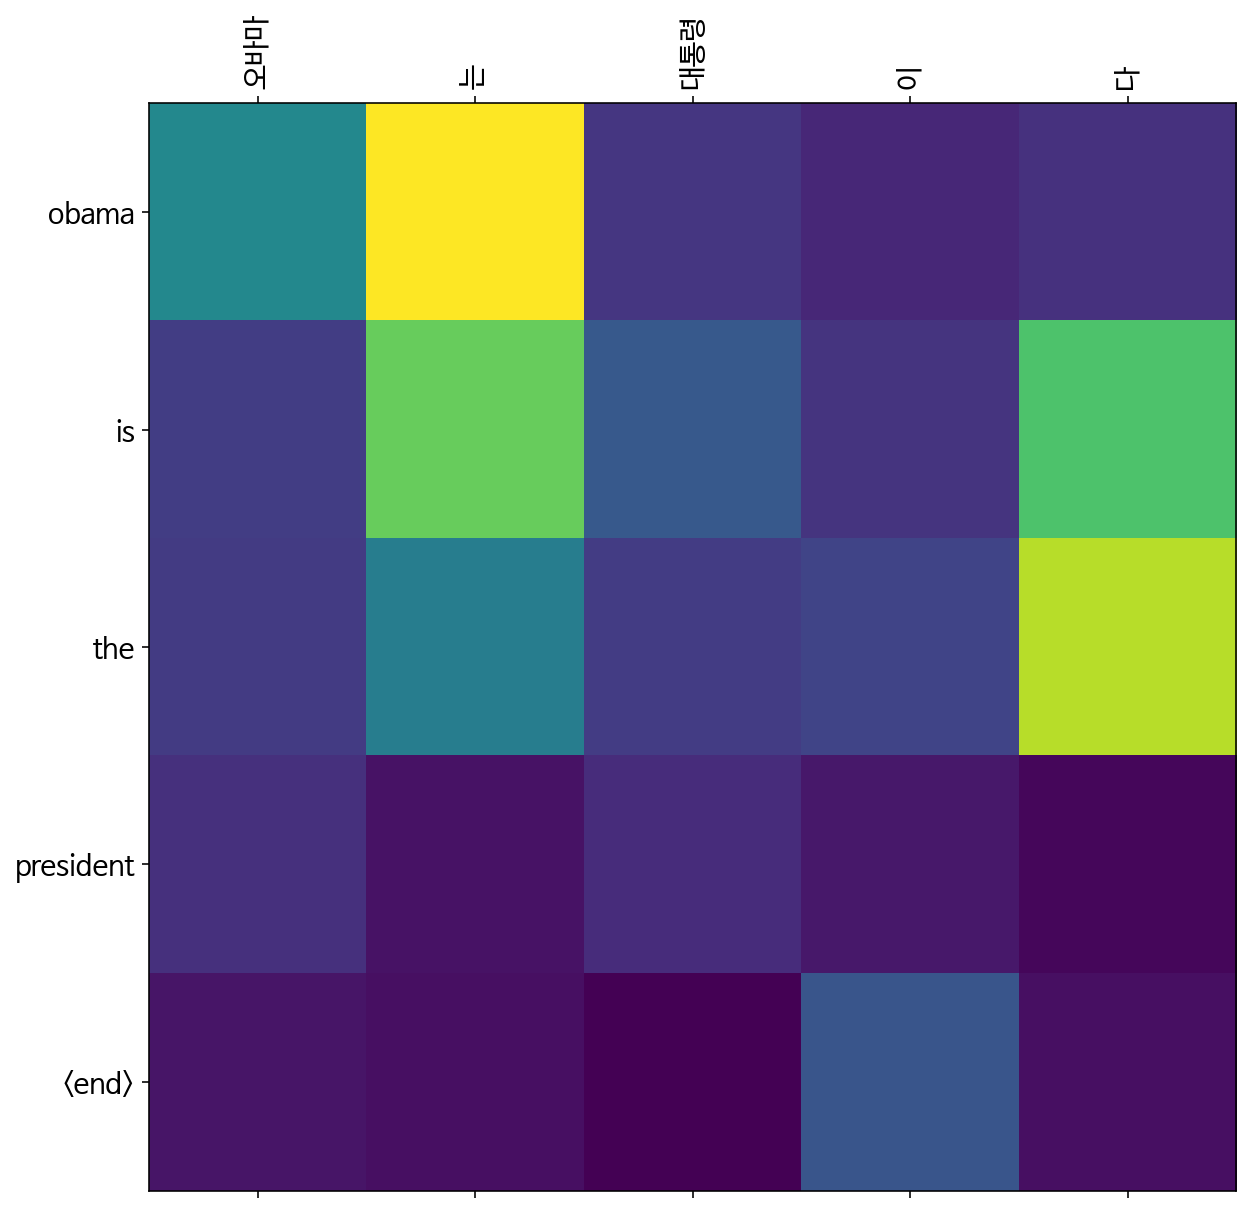

Input: ['시민', '들', '은', '도시', '속', '에', '산다']
Predicted translation: the people want to be in the city <end> 


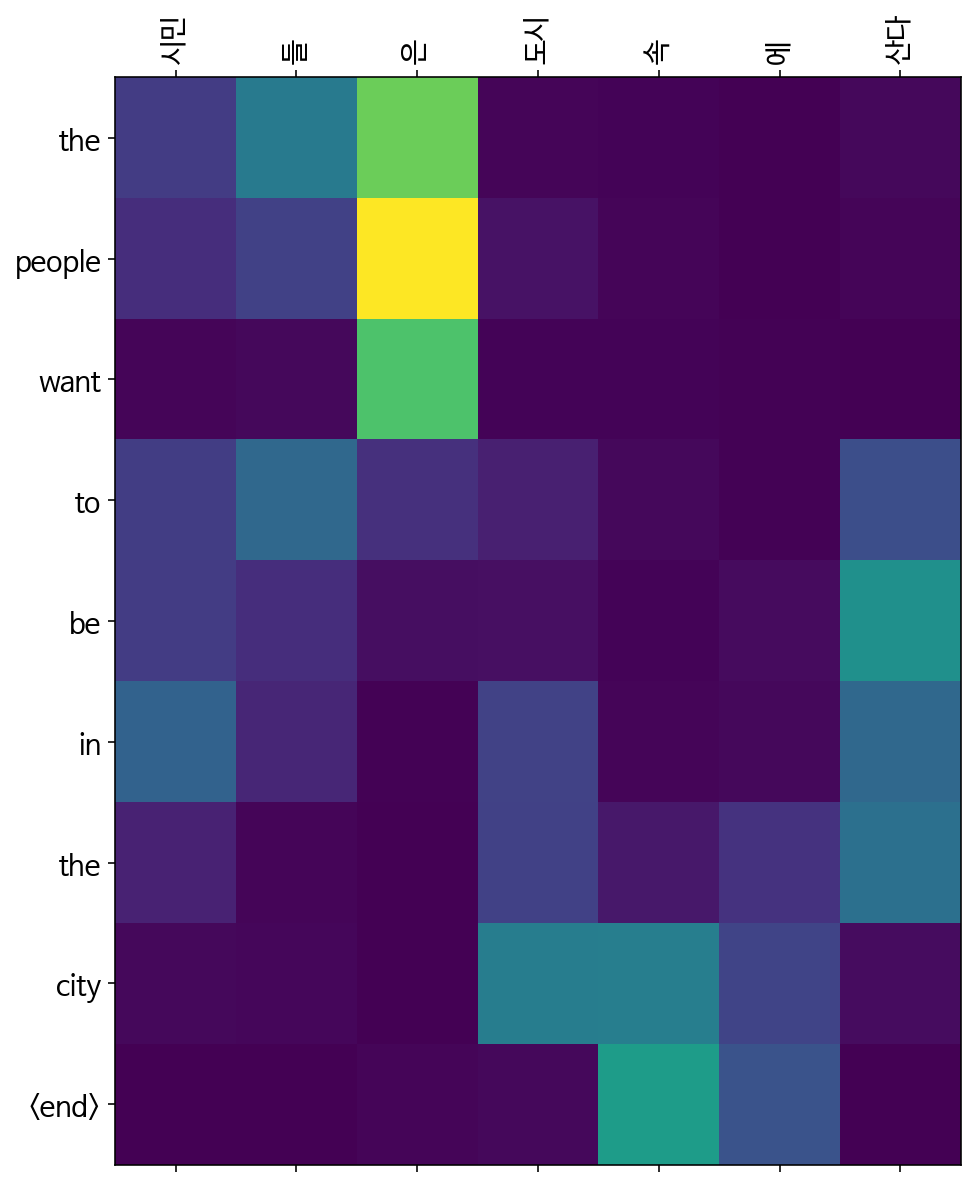

Input: ['커피', '는', '필요', '없', '다']
Predicted translation: its not just not enough <end> 


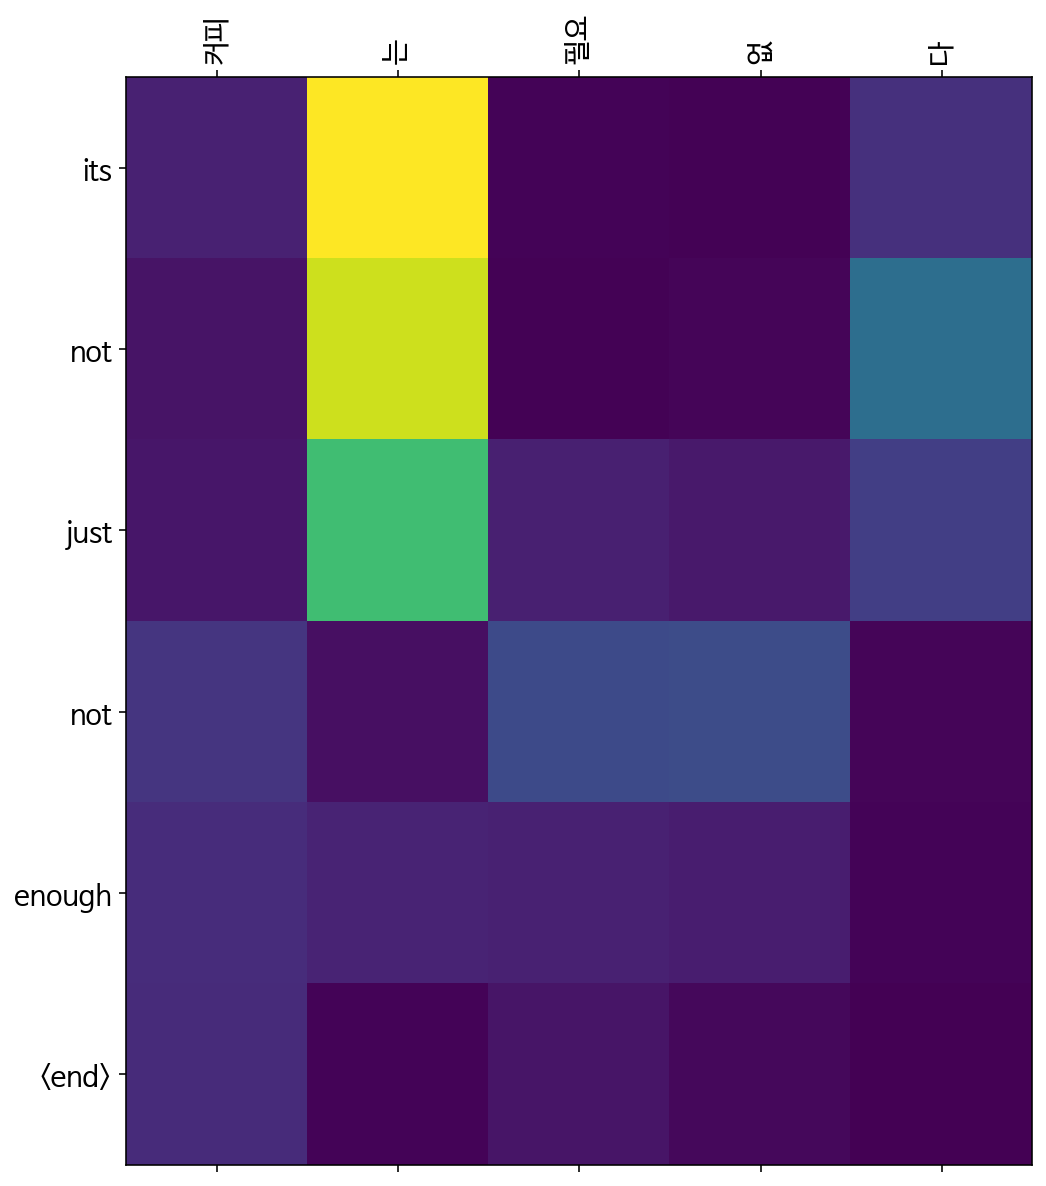

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다']
Predicted translation: seven deaths have died last month <end> 


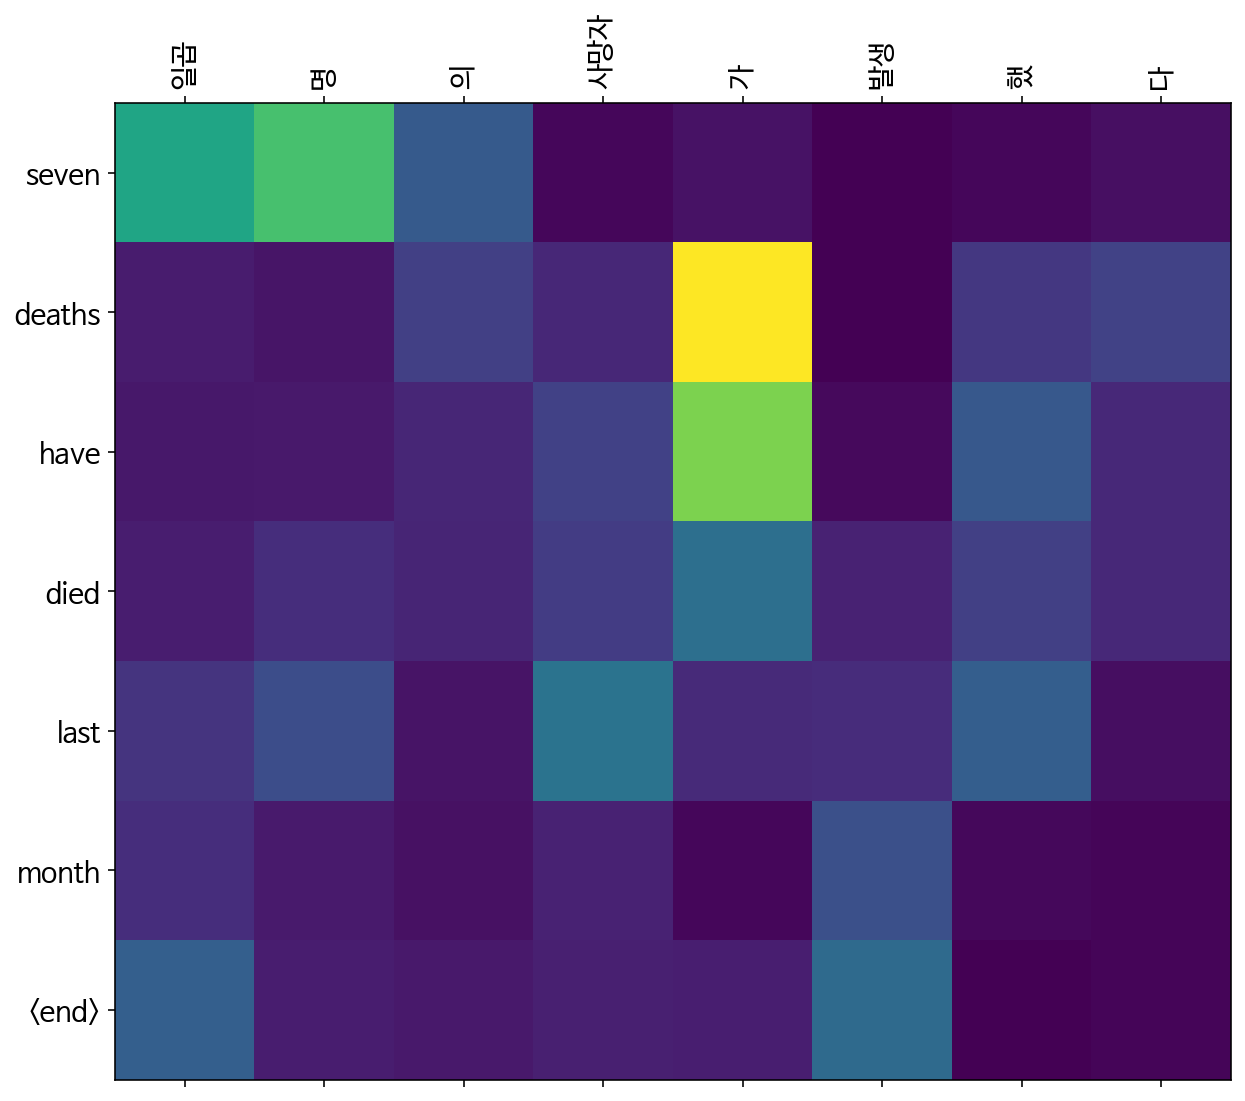

In [ ]:
for example in examples:
        translate(example, encoder, decoder, show_attention=True)

어텐션 히트맵을 시각화해보면 번역이 잘 됐더라도 우연히 잘 된 것일 거라는 생각이 듭니다.

마지막으로 커스텀 문장을 번역기에 넣어보고 얼마나 잘 번역이 되나 확인해보겠습니다.

In [ ]:
translate("안녕하세요?", encoder, decoder)

Input: ['안녕', '하', '세요', '?']
Predicted translation: you can you feel more <end> 


In [ ]:
translate("지금 우리는 무엇을 준비해야 하는가", encoder, decoder)

Input: ['지금', '우리', '는', '무엇', '을', '준비', '해야', '하', '는가']
Predicted translation: “well be a very nice things that is a very important anyway ? <end> 


In [ ]:
translate('나는 "당신이 예상하지 $0.99 못한 (글)을 쓸거야."', encoder, decoder)

Input: ['나', '는', '당신', '이', '예상', '하', '지', '$', '099', '못한', '(', '글', ')', '을', '쓸', '거', '야']
Predicted translation: i dont think i could be able to be a good time <end> 


`$`, `&`, `(`, `)` 같은 특수문자도 번역을 해줄 수 있지 있을까 기대하면서 제거하지 않았었는데

결과가 아주 처참합니다.

- - -
## 마무리하며

데이터가 지저분하면 얼마나 지저분한거지? 쓸데없는 컬럼이 많나? 싶었는데요.

이렇게 지저분할 줄은 몰랐습니다. 데이터셋을 만든 사람을 한 번 만나보고 싶네요.

그래도 좋은 번역기가 나오길 꿈꾸면서 최대한 데이터 전처리에 힘을 쓰고,

학습도 오래 걸려서 잘 때마다 까먹지 않고 파라미터 실험용 학습을 돌려놓고 잤습니다.

그럼에도 번역기의 성능은 좋아진 것 같지가 않네요.

원하는 결과가 안나오는데 원인이 데이터셋의 난이도에 있을 것이라고 생각하니까

어텐션의 원리를 살펴보고 모델을 수정하기보다는 오히려 데이터 전처리에만 힘을 쏟아 부운 것 같습니다.